In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [76]:
results_dir = '../evaluating_responses/part_1/'

In [79]:
import csv
from BlockingPairs import blockingPairs
import json

combined = [['Model', 'Status', 'Culture', 'Size', 'Instability', 'Optimality']]
file_names = {
    'DeepSeek-8B-Vanilla': 'ds_llama_8b_corrected.csv',
    'DeepSeek-8B-FT (r=16)': 'ds_llama_8b_16_corrected.csv',
    'DeepSeek-8B-FT (r=32)': 'ds_llama_8b_32_corrected.csv',
    'DeepSeek-14B-Vanilla': 'ds_qwen_14b_corrected.csv',
    'DeepSeek-14B-FT (r=16)': 'ds_qwen_14b_16_corrected.csv',
    'DeepSeek-14B-FT (r=32)': 'ds_qwen_14b_32_corrected.csv',
    'Qwen-QwQ-32B-Vanilla': 'qwen_qwq_corrected.csv',
    'Qwen-QwQ-32B-FT (r=16)': 'qwen_qwq_16_corrected.csv',
    'Qwen-QwQ-32B-FT (r=32)': 'qwen_qwq_32_corrected.csv',
    # 'Qwen-32B-FT-Hard (r=32)': 'qwen_qwq_32_lar_corrected.csv',
}

def JSONMatchToList(json_match_string):
    json_match_string = json_match_string.replace(" ", "")
    if json_match_string.endswith("],]"):
        pairs = json_match_string[1:-2].split('],[')
    else:
        pairs = json_match_string[1:-1].split('],[')
    
    # print("IN JSON TO STR FUNC")
    # print(pairs)

    # Step 2: Extract the W number from each pair and convert to integer
    result = []
    for pair in pairs:
        # Split the pair and take the second element (Wj), then extract the number
        w_value_str = (pair.split(',')[1][1:])
        if w_value_str[-1] == "]":
            if w_value_str[-2] == "]":
                w_value = int(w_value_str[:-2])
            else:
                w_value = int(w_value_str[:-1])
        else:
            w_value = int(w_value_str)
        result.append(w_value)

    # Step 3: Print the resulting list
    return result
    # print(result)  # Output: [7, 2, 9, 5, 4, 1, 6, 8, 10, 3]

def JSONobjToList(json_obj, n):
    if not json_obj:
        print("EMPTY JSON OBJ")
        return [], 'empty'
    matching = []
    for m in range(1, n+1):
        mstring = f"M{m}"
        if mstring not in json_obj or not json_obj[mstring] or json_obj[mstring].lower().strip() == 'none':
            matching.append(0)
        else:
            try:
                woman = int(json_obj[mstring][1:])
                matching.append(woman)
            except:
                print(f"WRONG VALUE FORMAT: {json_obj[mstring]}")
                return matching, f"For example, {mstring}'s match is given the incorrect format - {json_obj[mstring]}. "
    return matching, "okay"

def jaccard_similarity(list1, list2):
    set1 = set()
    set2 = set()
    for m, w in enumerate(list1):
        set1.add((m+1, w))
    for m, w in enumerate(list2):
        set2.add((m+1, w))

    jaccard_sim = len(set1.intersection(set2))/len(set1.union(set2))

    return jaccard_sim, len(set1.intersection(set2))


for culture in ['ic', 'womanmaster']:
    for size in [10,20,50]:
        instances_data = pd.read_csv(f'../instances_matchings/{size}_{culture}_processed.csv')
        # for row in instances_data.values:
        #     rand_match = JSONMatchToList(row[12])
        #     men_opt = JSONMatchToList(row[6])
        #     bp = blockingPairs(size, row[4], row[5], np.array(rand_match), "weak")
        #     bplist = bp['blockingPairs']
        #     male_set, female_set = set(), set()
        #     for man, woman in bplist:
        #         female_set.add(woman)
        #         male_set.add(man)
        #     instability = round((len(female_set)+len(male_set))*100/(size*2), 2)
        #     # print(instability)
        #     # print(blocked, len(male_set), len(female_set), i)
        #     js, inter = jaccard_similarity(rand_match, men_opt)
        #     combined.append(['Random', culture, size, instability, round(inter*100/(size), 2)])
        for model in file_names:
            if 'Qwen' in model:
                model_name = '-'.join(model.split('-')[:3])
                model_status = '_'.join(model.split('-')[3:])
            else:
                model_name = '-'.join(model.split('-')[:2])
                model_status = '_'.join(model.split('-')[2:])

            # print(model.split('_'), model_status)
            model_data = pd.read_csv(results_dir+file_names[model])
            subset = model_data[(model_data['Culture'] == culture) & (model_data['Size'] == size)]
            # print(model, culture, size, len(subset[subset['Correctness'] == 1]))
            for i, row in enumerate(subset.values):
                if row[-1] != 'Processed smoothly.': continue
                answer, verdict = JSONobjToList(json.loads(row[3].replace('\'', '\"')), size)
                men_opt = JSONMatchToList(instances_data['men_opt'].values[i])
                js, inter = jaccard_similarity(answer, men_opt)
                male_set, female_set = set(), set()
                blocked = row[6].replace('[', '').replace(']', '').split(', ')
                # print(row[6])
                if row[4] == 1: 
                    combined.append([model_name, model_status, culture, size, 0, 100])
                    continue
                for i, agent in enumerate(blocked):
                    if i%2:
                        female_set.add(agent)
                    else:
                        male_set.add(agent)
                instability = round((len(female_set)+len(male_set))*100/(size*2), 2)
                # print(instability)
                # print(blocked, len(male_set), len(female_set), i)
                combined.append([model_name, model_status, culture, size, instability, round(row[-2]*100/(size), 2)])
                # print(model, culture, size, row[-2], inter)

with open(results_dir+'combined_metrics_ft.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(combined)




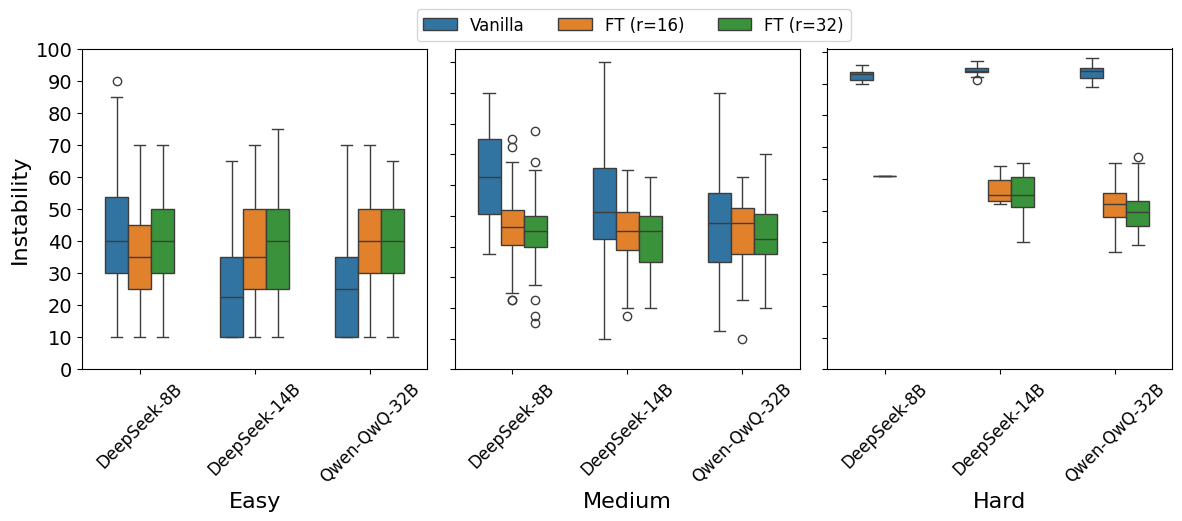

In [84]:
import seaborn as sns
p = 0
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
yticks = {
    10: [10*i for i in range(11)],
    20: [10*i for i in range(11)],
    50: [10*i for i in range(11)]
}
names = {
    10: "Easy",
    20: "Medium",
    50: "Hard",
}

order  = list(file_names.keys())
total_df = pd.read_csv(results_dir+'combined_metrics_ft.csv')
for p, size in enumerate([10, 20, 50]):
    # for culture in ['ic', 'womanmaster']:
    df = total_df[(total_df['Size'] == size) & (total_df['Instability'] > 0)][['Model', 'Status', 'Instability']]
    maxval = max(df['Instability'].values)
    models = df['Model'].unique()
    # print(df.head())
    ax = sns.boxplot(y="Instability", x="Model", data=df, orient='v', hue="Status", width=0.6, ax=axes[p], order=models)
    ax.set_ylabel("Instability" if size < 20 else '', fontsize=16)
    ax.set_yticks(yticks[size])
    ax.set_yticklabels(yticks[size] if size < 20 else ['']*11, fontsize = 14)
    ax.set_xlabel(f"{names[size]}", fontsize=16)
    ax.set_xticklabels(models, rotation=45, fontsize=12)
    p += 1
    ax.legend([], [], frameon=False)
    handles, labels = ax.get_legend_handles_labels()
        

fig.legend(handles, labels, bbox_to_anchor=(0.72,1.05), fontsize=12, ncol = 5)

fig.tight_layout()
fig.savefig(results_dir+"optimality_ft.pdf", bbox_inches="tight")


In [72]:
from scipy import stats

combined = pd.read_csv(results_dir+'combined_metrics_ft.csv')
for size in [10,20,50]:
    print(f'Size {size} $$$$$$$$$$$$$$$$$$$$$\n')
    for model in file_names:
        if 'FT' in model: continue
        model_name = '-'.join(model.split('-')[:2])
        van_data = combined[(combined['Model'] == model_name) & (combined['Size'] == size) & (combined['Status']=='Vanilla')]['Instability'].values
        ft_data1 = combined[(combined['Model'] == model_name) & (combined['Size'] == size) & (combined['Status']=='FT (r=16)')]['Instability'].values
        ft_data2 = combined[(combined['Model'] == model_name) & (combined['Size'] == size) & (combined['Status']=='FT (r=32)')]['Instability'].values
        ft_data3 = combined[(combined['Model'] == model_name) & (combined['Size'] == size) & (combined['Status']=='FT_Hard (r=32)')]['Instability'].values

        test = stats.ttest_ind(van_data, ft_data1, equal_var=False)
        if test.pvalue < 0.05: 
            print(model_name)
            print(f'Vanilla: {round(sum(van_data)/len(van_data), 2)} (num valid: {len(van_data)})')
            print(f'Fine-tuned (r=16): {round(sum(ft_data1)/len(ft_data1), 2)} (num valid: {len(ft_data1)})')
            # print(test)
            print()

        test = stats.ttest_ind(van_data, ft_data2, equal_var=False)
        if test.pvalue < 0.05: 
            print(model_name)
            print(f'Vanilla: {round(sum(van_data)/len(van_data), 2)} (num valid: {len(van_data)})')
            print(f'Fine-tuned (r=32): {round(sum(ft_data2)/len(ft_data2), 2)} (num valid: {len(ft_data2)})')
            # print(test)
            print()

        test = stats.ttest_ind(ft_data3, ft_data2, equal_var=False)
        print(test, f'(num valid: {len(ft_data3)})')
        if test.pvalue < 0.05: 
            print(model_name)
            print(f'Fine-tuned_Hard: {round(sum(ft_data3)/len(ft_data3), 2)} (num valid: {len(ft_data3)})')
            print(f'Fine-tuned (r=32): {round(sum(ft_data2)/len(ft_data2), 2)} (num valid: {len(ft_data2)})')
            # print(test)
            print()

Size 10 $$$$$$$$$$$$$$$$$$$$$

Llama-8B
Vanilla: 41.02 (num valid: 93)
Fine-tuned (r=16): 35.85 (num valid: 100)

TtestResult(statistic=nan, pvalue=nan, df=nan) (num valid: 0)
Qwen-14B
Vanilla: 20.66 (num valid: 99)
Fine-tuned (r=16): 35.5 (num valid: 100)

Qwen-14B
Vanilla: 20.66 (num valid: 99)
Fine-tuned (r=32): 37.05 (num valid: 100)

TtestResult(statistic=nan, pvalue=nan, df=nan) (num valid: 0)
Qwen-32B
Vanilla: 18.87 (num valid: 97)
Fine-tuned (r=16): 37.2 (num valid: 100)

Qwen-32B
Vanilla: 18.87 (num valid: 97)
Fine-tuned (r=32): 39.2 (num valid: 100)

TtestResult(statistic=-2.4500053705633964, pvalue=0.015199392608311534, df=188.2929527077795) (num valid: 100)
Qwen-32B
Fine-tuned_Hard: 34.4 (num valid: 100)
Fine-tuned (r=32): 39.2 (num valid: 100)

Size 20 $$$$$$$$$$$$$$$$$$$$$

Llama-8B
Vanilla: 64.19 (num valid: 34)
Fine-tuned (r=16): 46.25 (num valid: 90)

Llama-8B
Vanilla: 64.19 (num valid: 34)
Fine-tuned (r=32): 45.21 (num valid: 82)

TtestResult(statistic=nan, pvalue=nan

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/76/q6l8fqjj31n_72p5b5xz4vg40000gn/T/ipykernel_27168/2089622650.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=75, fontsize=12)
/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/var/folders/76/q6l8fqjj31n_72p5b5xz4vg40000gn/T/ipykernel_27168/2089622650.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=75, fontsiz

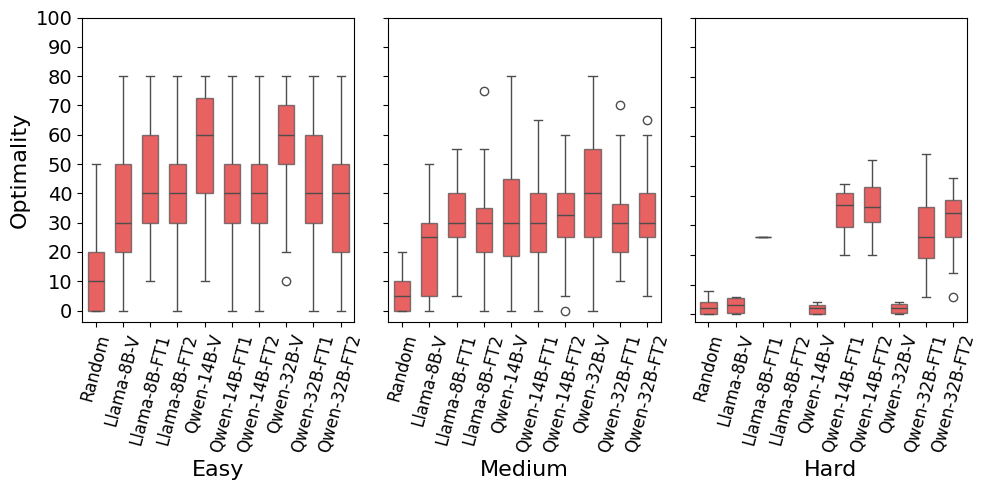

In [23]:
import seaborn as sns
p = 0
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
yticks = {
    10: [10*i for i in range(11)],
    20: [10*i for i in range(11)],
    50: [10*i for i in range(11)]
}
names = {
    10: "Easy",
    20: "Medium",
    50: "Hard",
}

order  = ['Random'] + list(file_names.keys())
total_df = pd. read_csv(results_dir+'combined_metrics_ft.csv')
for size in [10, 20, 50]:
    # for culture in ['ic', 'womanmaster']:
    df = total_df[(total_df['Size'] == size) & (total_df['Instability'] > 0)]
    maxval = max(df['Optimality'].values)
    models = df['Model'].unique()
    ax = sns.boxplot(y="Optimality", x="Model", data=df, orient='v', width=0.6, ax=axes[p], boxprops=dict(alpha=0.7), color='red', order=order)
    ax.set_ylabel("Optimality" if size < 20 else '', fontsize=16)
    ax.set_yticks(yticks[size])
    ax.set_yticklabels(yticks[size] if size < 20 else ['']*11, fontsize = 14)
    ax.set_xlabel(f"{names[size]}", fontsize=16)
    ax.set_xticklabels(order, rotation=75, fontsize=12)
    p += 1

fig.tight_layout()
fig.savefig(results_dir+"optimality_ft.pdf", bbox_inches="tight")
